## Fetch Traffic Data

Download raw traffic data from https://roadtraffic.dft.gov.uk/downloads/

In [ ]:
import pandas as pd
import zipfile 
import io
import requests 
import os 

def get_dft_traffic_data(road_name="A406", url="https://storage.googleapis.com/dft-statistics/road-traffic/downloads/data-gov-uk/dft_traffic_counts_raw_counts.zip"):
    """
    Download and preprocess DfT traffic counts CSV, filter for a specific road.

    Args:
        road_name (str): Name of the road to filter (e.g., "A406").
        url (str): URL of the DfT traffic counts CSV.

    Returns:
        pd.DataFrame: Clean DataFrame with datetime index and traffic counts.
    """
    response = requests.get(url)

    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
        files = [f for f in zip_file.namelist() if not f.startswith('__MACOSX/')]
        if len(files) > 1:
            raise ValueError("Multiple files found in ZIP file")
        file = files[0]
        with zip_file.open(file) as f:
            df = pd.read_csv(f,low_memory=False)
        
    # Filter for the road
    road_df = df[df["road_name"] == road_name].copy()
    if road_df.empty:
        raise ValueError(f"No data found for road '{road_name}'")

    # create datetime column from date and time columns
    road_df['datetime'] = pd.to_datetime(road_df['count_date'] + ' ' + road_df['hour'].astype(str) + ':00:00')
    road_df.set_index('datetime', inplace=True)
    road_df.sort_index(inplace=True)
    
    print(f"RL-ready traffic data prepared for road '{road_name}'. Total rows: {len(road_df)}")

    # save to csv
    os.makedirs("../data/processed", exist_ok=True)
    road_df.to_csv(f"../data/processed/dft_traffic_{road_name}.csv", index=False)
    print(f"Data saved to ../data/processed/dft_traffic_{road_name}.csv")
    return road_df


road_df = get_dft_traffic_data("A406")


RL-ready traffic data prepared for road 'A406'. Total rows: 11016
Data saved to ../data/processed/dft_traffic_A406.csv


In [ ]:
# read the processed data
road_df = pd.read_csv("../data/processed/dft_traffic_A406.csv")


In [33]:
road_df.columns

Index(['count_point_id', 'direction_of_travel', 'year', 'count_date', 'hour',
       'region_id', 'region_name', 'region_ons_code', 'local_authority_id',
       'local_authority_name', 'local_authority_code', 'road_name',
       'road_category', 'road_type', 'start_junction_road_name',
       'end_junction_road_name', 'easting', 'northing', 'latitude',
       'longitude', 'link_length_km', 'link_length_miles', 'pedal_cycles',
       'two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches',
       'LGVs', 'HGVs_2_rigid_axle', 'HGVs_3_rigid_axle',
       'HGVs_4_or_more_rigid_axle', 'HGVs_3_or_4_articulated_axle',
       'HGVs_5_articulated_axle', 'HGVs_6_articulated_axle', 'all_HGVs',
       'all_motor_vehicles', 'datetime'],
      dtype='object')

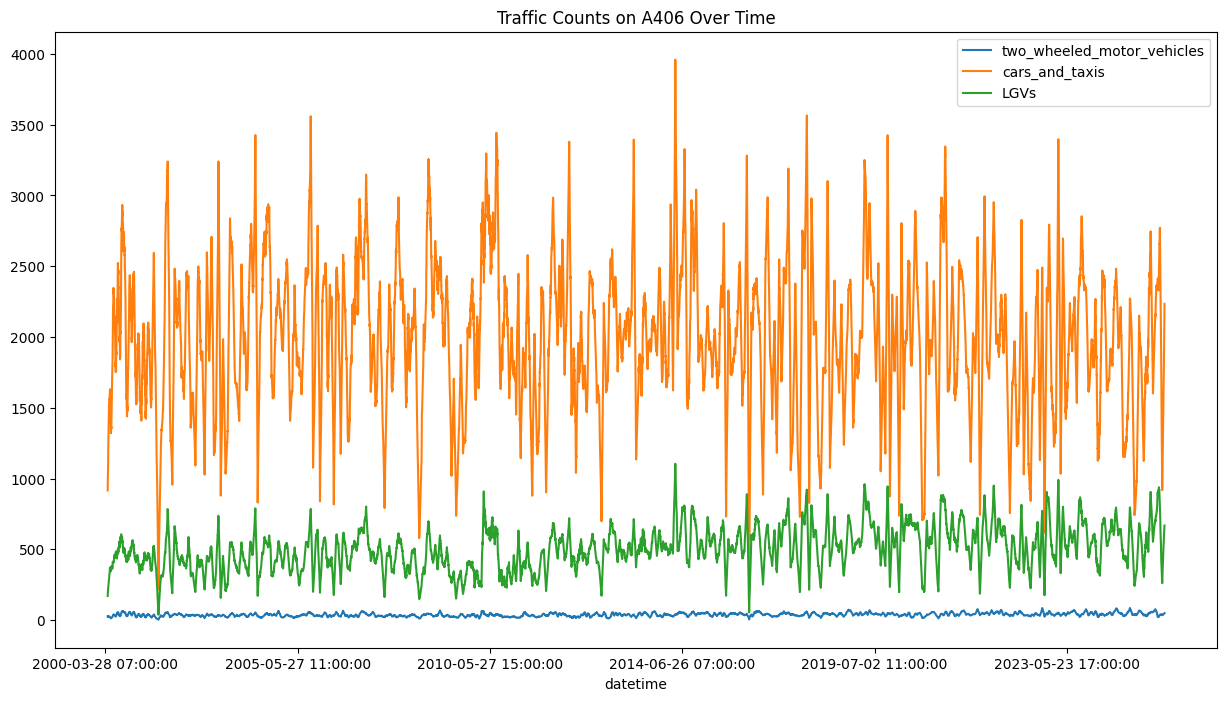

In [42]:
import matplotlib.pyplot as plt

columns_of_interest = [ "two_wheeled_motor_vehicles", "cars_and_taxis", "LGVs"]
(road_df[columns_of_interest]
 .rolling(24)
 .mean()
.plot(
    figsize=(15,8), 
    title="Traffic Counts on A406 Over Time"
)
);

In [43]:
road_df.describe()

,count_point_id,year,hour,region_id,local_authority_id,easting,northing,latitude,longitude,link_length_km,...,buses_and_coaches,LGVs,HGVs_2_rigid_axle,HGVs_3_rigid_axle,HGVs_4_or_more_rigid_axle,HGVs_3_or_4_articulated_axle,HGVs_5_articulated_axle,HGVs_6_articulated_axle,all_HGVs,all_motor_vehicles
count,11016.000000,11016.000000,11016.000000,11016.0,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,...,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000
mean,38132.189542,2012.860566,12.500000,6.0,110.318083,529964.660131,188318.254902,51.578690,-0.125741,1.424837,...,14.162945,503.352487,109.385802,15.012618,25.862745,6.963962,17.004085,32.120098,206.349310,2752.409495
std,22691.016329,7.311808,3.452209,0.0,33.987300,8392.200571,3474.874427,0.030519,0.121531,0.606989,...,9.565611,228.294145,69.571940,12.215872,21.387828,8.197288,15.788487,24.207696,118.144068,1013.779030
min,7055.000000,2000.000000,7.000000,6.0,57.000000,518630.000000,179050.000000,51.497803,-0.291530,0.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,90.000000
25%,17022.000000,2007.000000,9.750000,6.0,57.000000,522751.000000,185670.000000,51.551689,-0.230146,1.000000,...,7.000000,347.000000,60.000000,6.000000,10.000000,2.000000,7.000000,14.000000,115.750000,2071.000000
50%,37113.000000,2013.000000,12.500000,6.0,121.000000,527550.000000,188910.000000,51.581300,-0.159525,1.300000,...,13.000000,490.000000,102.000000,13.000000,22.000000,5.000000,12.000000,27.000000,195.000000,2732.000000
75%,56758.000000,2019.000000,15.250000,6.0,124.000000,536850.000000,191270.000000,51.605716,-0.025224,1.900000,...,19.000000,634.000000,148.000000,21.000000,38.000000,10.000000,22.000000,44.000000,281.000000,3381.250000
max,88048.000000,2024.000000,18.000000,6.0,167.000000,543792.000000,192500.000000,51.615900,0.071706,2.700000,...,189.000000,2442.000000,1636.000000,178.000000,694.000000,344.000000,149.000000,224.000000,2107.000000,8081.000000
